## Task 3

#### __Problem Description__

Generate a Quantum Support Vector Machine (QSVM) using the iris dataset 
and try to propose a kernel from a parametric quantum circuit to classify 
the three classes(setosa, versicolor, virginica) using the one-vs-all format,
the kernel only works as binary classification. Identify the proposal with
the lowest number of qubits and depth to obtain higher accuracy. You can 
use the UU† format or using the Swap-Test.


#### __Proposed Solution__

_QML framework used_: PennyLane

Two methods were investigated, each having one SVM per class and using one-vs-all format.

Gradient descent was used to find the optimal initialization parameters for the kernels by maximizing kernel-target alignment. However, the corresponding gradients were extremely small. Hence, we didn't observe significant difference in performance.

1. __Method 1__: 
    - Description:
        - Number of qubits: 2
        - Number of parameters per SVM: 5
        - QML operations/gates used in each kernel: AmplitudeEmbedding, RZ, RY, CRZ
    - Shortcomings:
        - Although it acheived almost perfect classification for 'class 0' and 'class 2', the SVM for class 1 labelled all datapoints as 0 (negative). 
        - Possible Explanation: 
            - As shown in the visualization below, 'class 1' datapoints falls in between 'class 0' and 'class 2'. Therefore, there is a possibility that using one-vs-all format with amplitude embedding and given depth doesn't allow the classes to be properly separated/ non-linearly transformed. 
            - Moreover, if the relative orientation of the datapoints remain the same, this SVM would have equal number of negative samples on either side. Thus, making it even more difficult to create a proper separating hyperplane. 
    - Variations: To combat the shortcomings, several variations were tried:
        - Increase the number of qubits:
            - Increased the number of qubits to 3 (this allows us to encode upto 8 features). Also, padded the feature vectors with 1 to have non-zero amplitude for remaining quantum states. 
        - Pre-process data:
            - Sinusoidal - To non-linearly transform the feature vectors. 
    - Results:
        | Variation | | Train Accuracy | | | Test Accuracy | | |
        | --- | --- | --- | --- | --- | --- | --- | --- |
        | | | Class 0 | Class 1 | Class 2 | Class 0 | Class 1 | Class 2 |
        | No pre-processing | | 100% | 66.67% | 96.19% | 100% | 66.67% | 95.83% |
        | 3 qubits | | 100% | 66.67% | 95.24% | 100%| 66.67% | 95.83% |
        | Sinusodial pre-processing | | 100% | 79.05% | 78.10% | 100% | 80.25% | 85.19% |
        
        - '3 qubit' variation suffers from the same issue as the '2 qubit / No pre-processing' variation. Possibly because the increase in embedding space dimension still doesn't introduce enough non-linearity to separate 'class 1' samples.
        - 'Sinusodial pre-processing' variation does help alleviate this issue to some extent. 
 
2. __Method 2__:
    - Description:
        - Number of qubits: 4
        - Number of parameters per SVM: 8
        - QML operations/gates used in each kernel: Hadamard, RZ, RY, CRZ
    - Results:
        | Train Accuracy | | | Test Accuracy | | |
        | --- | --- | --- | --- | --- | --- |
        | Class 0 | Class 1 | Class 2 | Class 0 | Class 1 | Class 2 |
        | 100% | 97.14% | 96.19% | 100% | 100% | 98.61% |

    
#### __Conclusion__

Depending on the acceptable margin of error, either method could be used. Method 1 produces QSVM with lowest computational cost. However, if allowed margin of error is lower, Method 2 produces next best QSVM in terms of computational cost. 

#### __Future Work__

As atleast 2 qubits are required to encode a feature vector of dimension 4, there could be possible variations of Method 1 that could further decrease depth/ increase accuracy. These would include combinations of differnet data pre-processing operations, parameter initialization techniques, and quantum gates for the kernels. However, given the time constraints, these directions would be explored outside the submission deadline. 

In [1]:
from pennylane import numpy as np
import pennylane as qml
from pennylane.templates import AngleEmbedding, StronglyEntanglingLayers

import matplotlib.pyplot as plt
import numpy
from tqdm import tqdm
import math

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
np.random.seed(999)

### Data Visualization

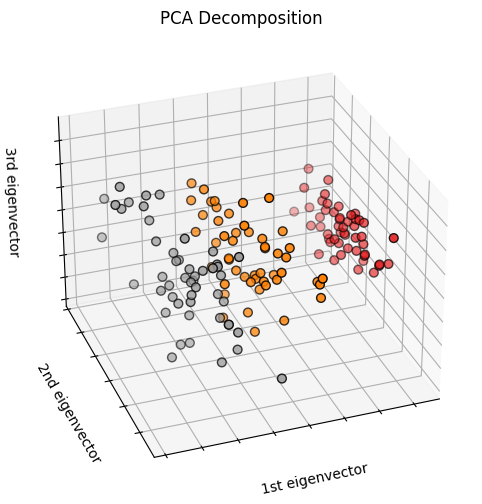

In [3]:
iris = datasets.load_iris()

fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

X_pca = PCA(n_components=3).fit_transform(iris.data)
ax.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    X_pca[:, 2],
    c=iris.target,
    cmap=plt.cm.Set1,
    edgecolor="k",
    s=40,
)

ax.set_title("PCA Decomposition")
ax.set_xlabel("1st eigenvector")
ax.xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.zaxis.set_ticklabels([])

plt.show()

### Dataset

Dataset class to streamline data loading and processing. 

In [4]:
class Dataset():
    """Dataset class to streamline data loading and processing for the Iris dataset.
    
    Args:
        n_train_samples_per_class (int): Training samples from each class included in the train-test split. Defaults to 35.
        preprocessing (str): Specifies the type of preprocessing applied on the feature vectors. Defaults to `None`.
        
    Attributes:
        X: Feature vectors for the complete Iris dataset.
        y: Target labels for the complete Iris dataset.
        X_train: Feature vectors in training set created while initialization.
        y_train: Target labels in training set created while initialization.
        X_test: Feature vectors in test set created while initialization.
        binary_labels_train: Dictionary of class-wise binarized labels for training data.
        binary_labels_test: Dictionary of class-wise binarized labels for test data.
    """
    
    def __init__(self, n_train_samples_per_class=35, preprocessing=None):
        iris = datasets.load_iris()
        self.X = self._prepare_features(iris.data, preprocessing=preprocessing)
        self.y = iris.target
        self._train_test_split(n_train_samples_per_class)
        self.binary_labels_train = dict([('class '+str(i), self.create_binary_labels(self.y_train, label=i)) for i in range(3)])
        self.binary_labels_test = dict([('class '+str(i), self.create_binary_labels(self.y_test, label=i)) for i in range(3)])
        
    def _prepare_features(self, X, preprocessing=None):
        if preprocessing == 'sinusodial':
            return numpy.sin(X)
        return X
    
    def _get_samples(self, X, y, n_samples_per_class, return_idx=False):
        """Generates perfectly balanced data samples of given length.
        
        Note:
            Assumes given dataset is perfectly class balanced and ordered. 
            
        Args:
            X: Feature vectors for the dataset to be sampled.
            y: Target labels for the dataset to be sampled.
            n_samples_per_class (int): Number of datapoints to sample from each class.
            return_idx (bool): If `True`, returns indices used for sampling. Else, returns samples. Defaults to `False`.
            
        Returns:
            Depending on `return_idx`, either the sampling indices or the sampled datapoints. 
        """
        assert len(y) % 3 == 0
        n_datapoints_per_class = len(y) // 3
        sampler = np.random.choice(list(range(n_datapoints_per_class)), n_samples_per_class).numpy()
        idx = []
        
        for i in sampler:
            idx.append([i+j*n_datapoints_per_class for j in [0, 1, 2]])
        idx = [i for j in idx for i in j]
        
        if return_idx:
            return idx
        else:
            return X[idx], y[idx]
    
    def create_binary_labels(self, y, label=0):
        """Binarizes input for the given target label.
        
        Args:
            y: Target labels to binarize.
            label (int): Class label used to create one-vs-all represetation. Defaults to `0`.
            
        Returns:
            Binarized labels in one-vs-all format.
        """
        assert label in [0, 1, 2]
        return (y==label).astype(int)
    
    def _train_test_split(self, n_train_samples_per_class):
        """Created train-test dataset split.
        
        Args:
            n_train_samples_per_class (int): Training samples from each class included in the train-test split.
        """
        train_idx = self._get_samples(self.X, self.y, n_train_samples_per_class, return_idx=True)
        test_idx = [i for i in range(len(self.y)) if i not in train_idx]
        self.X_train, self.y_train = self.X[train_idx], self.y[train_idx]
        self.X_test, self.y_test = self.X[test_idx], self.y[test_idx]
        
    def create_batch(self, flag='train', n_samples_per_class=2, binary_label=None):
        """Creates smaller batches of training/test dataset.
        
        Args:
            flag (str): Specifies whether to sample from training or test dataset. Defaults to `train`.
            n_samples_per_class (int): Number of samples from each class included in the batch. Defaults to 2.
            binary_label (int, None): If specified, uses this label to binarize taregt labels. Defaults to `None`.
            
        Returns:
            Sampled batch of given length.
        """
        if flag == 'train':
            X, y = self.X_train, self.y_train
        else:
            X, y = self.X_test, self.y_test
            
        sorting_idx = numpy.argsort(y)
        X, y = X[sorting_idx], y[sorting_idx]
        X_batch, y_batch = self._get_samples(X, y, n_samples_per_class=n_samples_per_class)
        
        if binary_label is not None:
            y_batch = self.create_binary_labels(y_batch, label=binary_label)
        
        return X_batch, y_batch

In [5]:
dataset = Dataset()
dataset_sin = Dataset(preprocessing='sinusodial')

### MultiClassQSVM

MultiClassQSVM class to streamline creation and processing of class-wise quantum SVMs

In [6]:
class MultiClassQSVM():
    """MultiClass QSVM model using one-vs-all classification format. Creates as many SVMs as there are classes.
    
    Args:
        n_qubits (int): Number of qubits used for the qunatum kernel.
        n_classes (int): Total number of classes in the classification task. Determines the number of SVMs created. 
        n_layers (int): Number of repetitions of the core layer. Determines the depth of the kernel. 
        method (str): Specifies whether to use 'Method 1' or 'Method 2'. 
        
    Attributes:
        dev: Instance of a device. Used to construct qunatum nodes. 
        wires: Sequence of wire labels.
        n_layers (int): Number of repetitions of the core layer. Determines the depth of the kernel.
        method (str): Specifies whether to use 'Method 1' or 'Method 2'.
        tags (list): List of tags used to store differnet components of the class-wise SVMs.  
        weights (dict): Dictionary of parameters used to create class-wise kernels. 
        qkernels (dict): Dictionary of class-wise kernels. 
        svms (dict): Dictionary of class-wise SVMs.
        
    """
    
    def __init__(self, n_qubits, n_classes, n_layers, method='method1'):
        self.dev = qml.device("default.qubit", wires=n_qubits)
        self.wires = self.dev.wires.tolist()
        self.n_layers = n_layers
        assert method in ['method1', 'method2']
        self.method = method
        
        self.tags = ['class '+str(i) for i in range(n_classes)]
        self.weights, self.qkernels = self._init_kernels()
        self.svms = None
        
    def _layer(self, x, W):
        """Defines the core layer of the embedding ansatz.
        
        Args:
            x: Feature vector
            W: Parameters for the quantum gates/operations.
        """
        offset = 1 if self.method=='method1' else 0
        for j, wire in enumerate(self.wires):
            if self.method == 'method1':
                qml.RZ(W[0, j], wires=[wire])
            else:
                qml.Hadamard(wires=[wire])
                qml.RZ(x[j % len(x)], wires=[wire])
            qml.RY(W[offset+0, j], wires=[wire])
            
        if len(self.wires) > 2:
            qml.broadcast(unitary=qml.CRZ, pattern="ring", wires=self.wires, parameters=W[offset+1])
        else:       
            qml.CRZ(W[offset+1, 0], self.wires)

    def _ansatz(self, x, W, pad_with=1.0):
        """Creates the embedding ansatz.
        
        Args:
            x: Feature vector.
            W: Parameters for the quantum gates/operations.
        """
        if self.method == 'method1':
            assert len(x) <= 2**len(self.wires)
            qml.AmplitudeEmbedding(x, self.wires, pad_with=pad_with, normalize=True)
        for j, layer_weights in enumerate(W):
            self._layer(x, layer_weights)

    def _random_weights(self):
        """Generates random initialization parameters for the ansatz."""
        inc = 1 if self.method == 'method1' else 0
        return np.random.uniform(0, 2 * np.pi, (self.n_layers, 2+inc, len(self.wires)), requires_grad=True)   
            
    def _kernel(self, x1, x2, W):
        """Defines the quantum kernel used by class-wise SVMs.
        
        Args:
            x1: Feature vectors for one of the datapoints.
            x1: Feature vector for the other datapoint.
            W : Parameters for the quantum gates/operations.
            
        Returns:
            Probability of observing the different quantum states. 
        """
        self._ansatz(x1, W)
        qml.adjoint(self._ansatz)(x2, W)
        return qml.probs(wires=self.wires)
    
    def _init_kernels(self):
        """Constructs QNodes for class-wise SVMs.
        
        Returns:
            weights (dict): Dictionary of initialization weights used for the quantum kernels.
            qkernels (dict):  Dictionary of class-wise quantum kernels.
        """
        weights, qkernels = {}, {}
        
        for tag in self.tags:
            init_weight = self._random_weights()
            qkernel = qml.QNode(self._kernel, self.dev)
            weights[tag] = init_weight
            qkernels[tag] = qkernel
            
        return weights, qkernels
    
    def print_kernels(self, x):
        """Prints quantum kernels for each class.
        
        Args: 
            x: sample feature vector.
        """
        for tag in self.tags:
            print('Kernal for '+tag+'\n')
            print(qml.draw(self.qkernels[tag])(x, x, self.weights[tag]))
    
    def _get_accuracy(self, X, y, svm):
        """Calculates prediction and accuracy for the given dataset-svm combination.
        
        Args:
            X: Feature vectors.
            y: Binarized target labels.
            svm: Class-wise SVM.
            
        Returns:
            pred: Prediction on the given dataset.
            acc: SVM's accuracy on the given dataset.
        """
        pred = svm.predict(X)
        acc = accuracy_score(pred, y)
        return pred, acc
    
    def get_target_alignment(self, X, Y, kernel=None, tag=None, assume_normalized_kernel=True, rescale_class_labels=True):
        """Calculates differentiable version of the kernel-target alignment metric. 
        
        Args:
            X: Feature vectors.
            y: Target labels.
            kernel: The kernel for which metric is calculated. If `None`, uses qkernels initialised earlier. Defaults to `None`.
            tag (str): Class tag used to fetch qkernel. Defaults to `None`.
            assume_normalized_kernel (bool): Specifies if the kernel is assumed to be normalized. Defaults to `True`.
            rescale_class_labels (bool): Specifies if the class labels should be rescaled to [0, 1]. Defaults to `True`.
            
        Returns:
            Kernel-alignment metric between the kernel and the target labels. 
        """
        assert kernel is not None or tag is not None
        
        if kernel is None:
            kernel = lambda x1, x2: self.qkernels[tag](x1, x2, self.weights[tag])[0]
            
        K = qml.kernels.square_kernel_matrix(X, kernel, assume_normalized_kernel=assume_normalized_kernel)

        if rescale_class_labels:
            nplus = np.count_nonzero(np.array(Y) == 1)
            nminus = len(Y) - nplus
            _Y = np.array([y / nplus if y == 1 else y / nminus for y in Y])
        else:
            _Y = np.array(Y)

        T = np.outer(_Y, _Y)
        inner_product = np.sum(K * T)
        norm = np.sqrt(np.sum(K * K) * np.sum(T * T))
        kta = inner_product / norm
        
        return kta
    
    def _get_optimal_kernel(self, dataset, tag, step_size=0.2, n_epochs=100, batch_size_per_class=4):
        """Finds optimal kernel by maximising kernel-alignment metric through gradient descent.
        
        Args:
            dataset: Iris dataset object.
            tag: Class tag used to fetch different kernel components.
            step_size (float): Step size used in gradient descent optimization. Defaults to 0.2.
            n_epochs (int): Number of epochs used while gradient descent optimization. Defaults to 100.
            batch_size_per_class (int): Determines batch size used per epoch. Defaults to 4.
            
        Returns:
            Quantum kernel with optimized parameters. 
        """
        W = self.weights[tag]
        opt = qml.GradientDescentOptimizer(step_size)
        
        for i in tqdm(range(n_epochs)):
            X_batch, y_batch = dataset.create_batch(n_samples_per_class=batch_size_per_class, binary_label=int(tag[-1]))
            cost = lambda _W: -self.get_target_alignment(
                        X_batch, 
                        y_batch, 
                        kernel=lambda x1, x2: self.qkernels[tag](x1, x2, _W)[0],
                    )
            W = opt.step(cost, W)
            
            if (i+1)%50 == 0:
                curr_alignment = self.get_target_alignment(
                                        dataset.X_train, 
                                        dataset.binary_labels_train[tag], 
                                        kernel=lambda x1, x2: self.qkernels[tag](x1, x2, W)[0],
                                    )
                print(f"Step {i+1} Alignment: {curr_alignment:.3f}")
        
        return lambda x1, x2: self.qkernels[tag](x1, x2, W)[0]

    def fit_svms(self, dataset, kernels=None):
        """Creates class-wise quantum SVMs.
        
        Args:
            dataset: Iris dataset object.
            kernels: Quantum kernels for each class. If `None`, uses qkernels initialized earlier. Defaults to `None`.
            
        Returns:
            Class-wise quantum SVMs. 
        """
        svms = {}
        
        if kernels is None:
            kernels = dict([(tag, lambda x1, x2: self.qkernels[tag](x1, x2, self.weights[tag])[0]) for tag in self.tags])
        
        for tag in self.tags:
            X_train, y_train = dataset.X_train, dataset.binary_labels_train[tag]
            X_test, y_test = dataset.X_test, dataset.binary_labels_test[tag]
            svm = SVC(kernel=lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, kernels[tag])).fit(X_train, y_train)
            svms[tag] = svm
            _, train_acc = self._get_accuracy(X_train, y_train, svm)
            _, test_acc = self._get_accuracy(X_test, y_test, svm)
            print(f"The training accuracy of the {tag} SVM is {train_acc:.4f}")
            print(f"The test accuracy of the {tag} SVM is {test_acc:.4f}")
        
        self.svms = svms
        
        return svms

    def train(self, dataset, step_size=0.2, n_epochs=100, batch_size_per_class=4):
        """Finds optimal parameters for the quantum kernels and creates corresponding class-wise SVMs. 
        
        Args:
            dataset: Iris dataset object.
            step_size (float): Step size used in gradient descent optimization. Defaults to 0.2.
            n_epochs (int): Number of epochs used while gradient descent optimization. Defaults to 100.
            batch_size_per_class (int): Determines batch size used per epoch. Defaults to 4. 
            
        Returns:
            Optimized class-wise quantum SVMs.
        """
        opt_kernels = {}
        
        for tag in self.tags:
            opt_kernel = self._get_optimal_kernel(dataset, tag, step_size=step_size, n_epochs=n_epochs, batch_size_per_class=batch_size_per_class)
            opt_kernels[tag] = opt_kernel

        opt_kernels = opt_kernels
        opt_svms = self.fit_svms(dataset, kernels=opt_kernels)
        
        return opt_svms            

### Method 1

In [10]:
# --- No pre-processing ---
qsvm1 = MultiClassQSVM(2, 3, 1, method='method1')
# qsvm1.fit_svms(dataset)
qsvm1.train(dataset, n_epochs=100, batch_size_per_class=5)

 50%|███████████████████████████████████████████████████                                                   | 50/100 [00:42<04:01,  4.83s/it]

Step 50 Alignment: 0.361


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:25<00:00,  1.17it/s]


Step 100 Alignment: 0.361


 50%|███████████████████████████████████████████████████                                                   | 50/100 [00:42<04:00,  4.80s/it]

Step 50 Alignment: 0.360


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:25<00:00,  1.17it/s]


Step 100 Alignment: 0.360


 50%|███████████████████████████████████████████████████                                                   | 50/100 [00:42<03:59,  4.80s/it]

Step 50 Alignment: 0.361


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:25<00:00,  1.17it/s]

Step 100 Alignment: 0.361


The training accuracy of the class 0 SVM is 1.0000
The test accuracy of the class 0 SVM is 1.0000
The training accuracy of the class 1 SVM is 0.6667
The test accuracy of the class 1 SVM is 0.6667
The training accuracy of the class 2 SVM is 0.9619
The test accuracy of the class 2 SVM is 0.9583


{'class 0': SVC(kernel=<function MultiClassQSVM.fit_svms.<locals>.<lambda> at 0x17795feb0>),
 'class 1': SVC(kernel=<function MultiClassQSVM.fit_svms.<locals>.<lambda> at 0x17795fd00>),
 'class 2': SVC(kernel=<function MultiClassQSVM.fit_svms.<locals>.<lambda> at 0x17795f9a0>)}

In [9]:
# --- 3 qubit ---
qsvm1_ = MultiClassQSVM(3, 3, 1, method='method1')
# qsvm1_.fit_svms(dataset_sin)
qsvm1_.train(dataset, n_epochs=100, batch_size_per_class=5)

 50%|███████████████████████████████████████████████████                                                   | 50/100 [01:12<06:46,  8.13s/it]

Step 50 Alignment: 0.360


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:24<00:00,  1.44s/it]


Step 100 Alignment: 0.360


 50%|███████████████████████████████████████████████████                                                   | 50/100 [01:11<06:41,  8.02s/it]

Step 50 Alignment: 0.360


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:23<00:00,  1.43s/it]


Step 100 Alignment: 0.360


 50%|███████████████████████████████████████████████████                                                   | 50/100 [01:11<06:41,  8.02s/it]

Step 50 Alignment: 0.360


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:24<00:00,  1.44s/it]

Step 100 Alignment: 0.360


The training accuracy of the class 0 SVM is 1.0000
The test accuracy of the class 0 SVM is 1.0000
The training accuracy of the class 1 SVM is 0.6667
The test accuracy of the class 1 SVM is 0.6667
The training accuracy of the class 2 SVM is 0.9524
The test accuracy of the class 2 SVM is 0.9583


{'class 0': SVC(kernel=<function MultiClassQSVM.fit_svms.<locals>.<lambda> at 0x16c28edd0>),
 'class 1': SVC(kernel=<function MultiClassQSVM.fit_svms.<locals>.<lambda> at 0x16c28e320>),
 'class 2': SVC(kernel=<function MultiClassQSVM.fit_svms.<locals>.<lambda> at 0x16c28fb50>)}

In [12]:
# --- Sinusodial ---
qsvm1 = MultiClassQSVM(2, 3, 1, method='method1')
# qsvm1.fit_svms(dataset_sin)
qsvm1.train(dataset_sin, n_epochs=100, batch_size_per_class=5)

 50%|███████████████████████████████████████████████████                                                   | 50/100 [00:46<04:28,  5.36s/it]

Step 50 Alignment: 0.532


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s]


Step 100 Alignment: 0.532


 50%|███████████████████████████████████████████████████                                                   | 50/100 [00:47<04:34,  5.49s/it]

Step 50 Alignment: 0.455


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:34<00:00,  1.06it/s]


Step 100 Alignment: 0.455


 50%|███████████████████████████████████████████████████                                                   | 50/100 [00:47<04:37,  5.56s/it]

Step 50 Alignment: 0.346


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]

Step 100 Alignment: 0.346


The training accuracy of the class 0 SVM is 1.0000
The test accuracy of the class 0 SVM is 1.0000
The training accuracy of the class 1 SVM is 0.7905
The test accuracy of the class 1 SVM is 0.8025
The training accuracy of the class 2 SVM is 0.7810
The test accuracy of the class 2 SVM is 0.8519


{'class 0': SVC(kernel=<function MultiClassQSVM.fit_svms.<locals>.<lambda> at 0x16b934e50>),
 'class 1': SVC(kernel=<function MultiClassQSVM.fit_svms.<locals>.<lambda> at 0x1751fe0e0>),
 'class 2': SVC(kernel=<function MultiClassQSVM.fit_svms.<locals>.<lambda> at 0x17795f0a0>)}

In [13]:
qsvm1.print_kernels(dataset_sin.X_train[0])

Kernal for class 0

0: ─╭AmplitudeEmbedding(M0)──RZ(4.95)──RY(6.25)─╭●────────╭●──────────RY(6.25)†──RZ(4.95)†
1: ─╰AmplitudeEmbedding(M0)──RZ(1.75)──RY(4.86)─╰RZ(4.21)─╰RZ(4.21)†──RY(4.86)†──RZ(1.75)†

──╭AmplitudeEmbedding(M0)†─┤ ╭Probs
──╰AmplitudeEmbedding(M0)†─┤ ╰Probs
Kernal for class 1

0: ─╭AmplitudeEmbedding(M0)──RZ(2.68)──RY(2.87)─╭●────────╭●──────────RY(2.87)†──RZ(2.68)†
1: ─╰AmplitudeEmbedding(M0)──RZ(2.08)──RY(4.43)─╰RZ(2.84)─╰RZ(2.84)†──RY(4.43)†──RZ(2.08)†

──╭AmplitudeEmbedding(M0)†─┤ ╭Probs
──╰AmplitudeEmbedding(M0)†─┤ ╰Probs
Kernal for class 2

0: ─╭AmplitudeEmbedding(M0)──RZ(3.41)──RY(1.12)─╭●────────╭●──────────RY(1.12)†──RZ(3.41)†
1: ─╰AmplitudeEmbedding(M0)──RZ(6.09)──RY(1.75)─╰RZ(6.17)─╰RZ(6.17)†──RY(1.75)†──RZ(6.09)†

──╭AmplitudeEmbedding(M0)†─┤ ╭Probs
──╰AmplitudeEmbedding(M0)†─┤ ╰Probs


### Method 2

In [14]:
qsvm2 = MultiClassQSVM(4, 3, 1, method='method2')

In [15]:
# qsvm2.fit_svms(dataset)
qsvm2.train(dataset, n_epochs=100, batch_size_per_class=5)

 50%|███████████████████████████████████████████████████                                                   | 50/100 [01:05<05:33,  6.67s/it]

Step 50 Alignment: 0.524


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:11<00:00,  1.31s/it]


Step 100 Alignment: 0.524


 50%|███████████████████████████████████████████████████                                                   | 50/100 [01:05<05:35,  6.71s/it]

Step 50 Alignment: 0.463


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:10<00:00,  1.31s/it]


Step 100 Alignment: 0.463


 50%|███████████████████████████████████████████████████                                                   | 50/100 [01:05<05:38,  6.76s/it]

Step 50 Alignment: 0.457


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:12<00:00,  1.32s/it]

Step 100 Alignment: 0.457


The training accuracy of the class 0 SVM is 1.0000
The test accuracy of the class 0 SVM is 1.0000
The training accuracy of the class 1 SVM is 0.9714
The test accuracy of the class 1 SVM is 1.0000
The training accuracy of the class 2 SVM is 0.9619
The test accuracy of the class 2 SVM is 0.9861


{'class 0': SVC(kernel=<function MultiClassQSVM.fit_svms.<locals>.<lambda> at 0x177867760>),
 'class 1': SVC(kernel=<function MultiClassQSVM.fit_svms.<locals>.<lambda> at 0x16b9c6b00>),
 'class 2': SVC(kernel=<function MultiClassQSVM.fit_svms.<locals>.<lambda> at 0x16b9357e0>)}

In [16]:
qsvm2.print_kernels(dataset.X_train[0])

Kernal for class 0

0: ──H──RZ(5.10)──RY(5.43)─╭●────────────────────────────╭RZ(2.90)─╭RZ(2.90)†──────────────────────
1: ──H──RZ(3.50)──RY(1.51)─╰RZ(0.09)─╭●──────────────────│─────────│─────────────────────╭●────────
2: ──H──RZ(1.40)──RY(0.52)───────────╰RZ(1.65)─╭●────────│─────────│──────────╭●─────────╰RZ(1.65)†
3: ──H──RZ(0.20)──RY(0.83)─────────────────────╰RZ(3.82)─╰●────────╰●─────────╰RZ(3.82)†──RY(0.83)†

──╭●──────────RY(5.43)†──RZ(5.10)†──H†─┤ ╭Probs
──╰RZ(0.09)†──RY(1.51)†──RZ(3.50)†──H†─┤ ├Probs
───RY(0.52)†──RZ(1.40)†──H†────────────┤ ├Probs
───RZ(0.20)†──H†───────────────────────┤ ╰Probs
Kernal for class 1

0: ──H──RZ(5.10)──RY(1.05)─╭●────────────────────────────╭RZ(1.31)─╭RZ(1.31)†──────────────────────
1: ──H──RZ(3.50)──RY(5.98)─╰RZ(4.06)─╭●──────────────────│─────────│─────────────────────╭●────────
2: ──H──RZ(1.40)──RY(0.28)───────────╰RZ(1.02)─╭●────────│─────────│──────────╭●─────────╰RZ(1.02)†
3: ──H──RZ(0.20)──RY(6.16)─────────────────────╰RZ(0.71)─╰●────────